# Variational Autoencoder

In this notebook, a variational autoencoder is built with keras and tensorflow. The data is model as a continuous mixture of Bernoulli distributions.

The code is modifed from a homework from a Coursera course: Bayesian Machine Learning 

In [2]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils

## Define the loss, which is the negative of the variational lower bound (VLB)
## The first term is the reconstruction loss (Bernoulli), the second term is KL divergence

In [3]:
def vlb_bernoulli_loss(x, x_decoded_mean, t_mean, t_log_var):
    """
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels) matrix with one image per row with zeros and ones
        x_decoded_mean: (batch_size x number_of_pixels) mean of the distribution p(x | t), real numbers from 0 to 1
        t_mean: (batch_size x latent_dim) mean vector of the (normal) distribution q(t | x)
        t_log_var: (batch_size x latent_dim) logarithm of the variance vector of the (normal) distribution q(t | x)
    Returns:
        A tf.Tensor with one element (averaged across the batch), VLB
    """    
    Reconstruction_loss = -tf.reduce_sum(x*tf.log(x_decoded_mean+1e-8)+ (1-x)*tf.log(1-x_decoded_mean + 1e-8),axis = 1)
    Reconstruction_loss = tf.reduce_mean(Reconstruction_loss)
    KL_divergence = tf.reduce_sum( (-t_log_var + tf.exp(t_log_var) + tf.square(t_mean) - 1)/2, axis = 1)
    KL_divergence = tf.reduce_mean(KL_divergence)
    
    VLB_neg = Reconstruction_loss + KL_divergence #This is negative VLB
    return VLB_neg

In [4]:
sess = tf.InteractiveSession()
K.set_session(sess)

## Define the VAE model

In [5]:
batch_size = 50
original_dim = 784 # Number of pixels in MNIST images.
latent_dim = 12 # d, dimensionality of the latent code t.
intermediate_dim = 256 # Size of the hidden layer.
epochs = 15

x = Input(batch_shape=(batch_size, original_dim))
def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim]))
    encoder.add(Dense(intermediate_dim, activation='relu'))
    encoder.add(Dense(2 * latent_dim))
    return encoder
encoder = create_encoder(original_dim)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])
h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args
    t_sample = t_mean + tf.exp(0.5*t_log_var) * tf.random_normal(tf.shape(t_mean), 0, 1, dtype=tf.float32)
    return t_sample

t = Lambda(sampling)([t_mean, t_log_var])

def create_decoder(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim]))
    decoder.add(Dense(intermediate_dim, activation='relu'))
    decoder.add(Dense(original_dim, activation='sigmoid'))
    return decoder
decoder = create_decoder(latent_dim)
x_decoded_mean = decoder(t)

In [6]:
loss = vlb_bernoulli_loss(x, x_decoded_mean, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)
# Keras will provide input (x) and output (x_decoded_mean) to the function that
# should construct loss, but since our function also depends on other
# things (e.g. t_means), it is easier to build the loss in advance and pass
# a function that always returns it.
vae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss=lambda x, y: loss)

## Prepare the MNIST dataset

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# One hot encoding.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

## Train the model

In [8]:
hist = vae.fit(x=x_train, y=x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_test, x_test),
               verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
 - 6s - loss: 145.6549 - val_loss: 123.3721
Epoch 2/15
 - 6s - loss: 121.3872 - val_loss: 117.1203
Epoch 3/15
 - 6s - loss: 117.0484 - val_loss: 115.1160
Epoch 4/15
 - 6s - loss: 114.8942 - val_loss: 113.0190
Epoch 5/15
 - 6s - loss: 113.4862 - val_loss: 111.7848
Epoch 6/15
 - 6s - loss: 112.4587 - val_loss: 111.5592
Epoch 7/15
 - 6s - loss: 111.7095 - val_loss: 110.4057
Epoch 8/15
 - 6s - loss: 111.0781 - val_loss: 110.2935
Epoch 9/15
 - 7s - loss: 110.5695 - val_loss: 109.1909
Epoch 10/15
 - 6s - loss: 110.1730 - val_loss: 109.3827
Epoch 11/15
 - 6s - loss: 109.7934 - val_loss: 108.9420
Epoch 12/15
 - 6s - loss: 109.5205 - val_loss: 108.9441
Epoch 13/15
 - 6s - loss: 109.2218 - val_loss: 108.1220
Epoch 14/15
 - 7s - loss: 108.9936 - val_loss: 107.9659
Epoch 15/15
 - 6s - loss: 108.8071 - val_loss: 108.0405


## Show some results

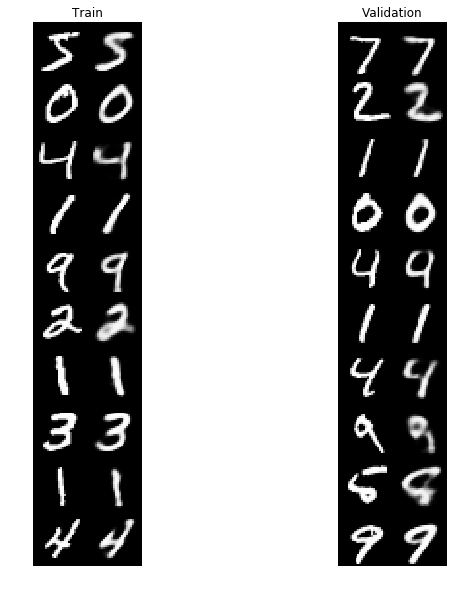

In [9]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (data, title) in enumerate(
            zip([x_train, x_test], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(x_decoded_mean, feed_dict={x: data[:batch_size, :]})
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

## Sample new data

In [10]:
n_samples = 50 
# sampled_im_mean is a tf.Tensor of size 10 x 784 with 10 random
sample_t = np.random.normal(loc = 0, scale = 1,size = (n_samples, latent_dim))
sampled_im_mean = sess.run(x_decoded_mean, feed_dict={t: sample_t})

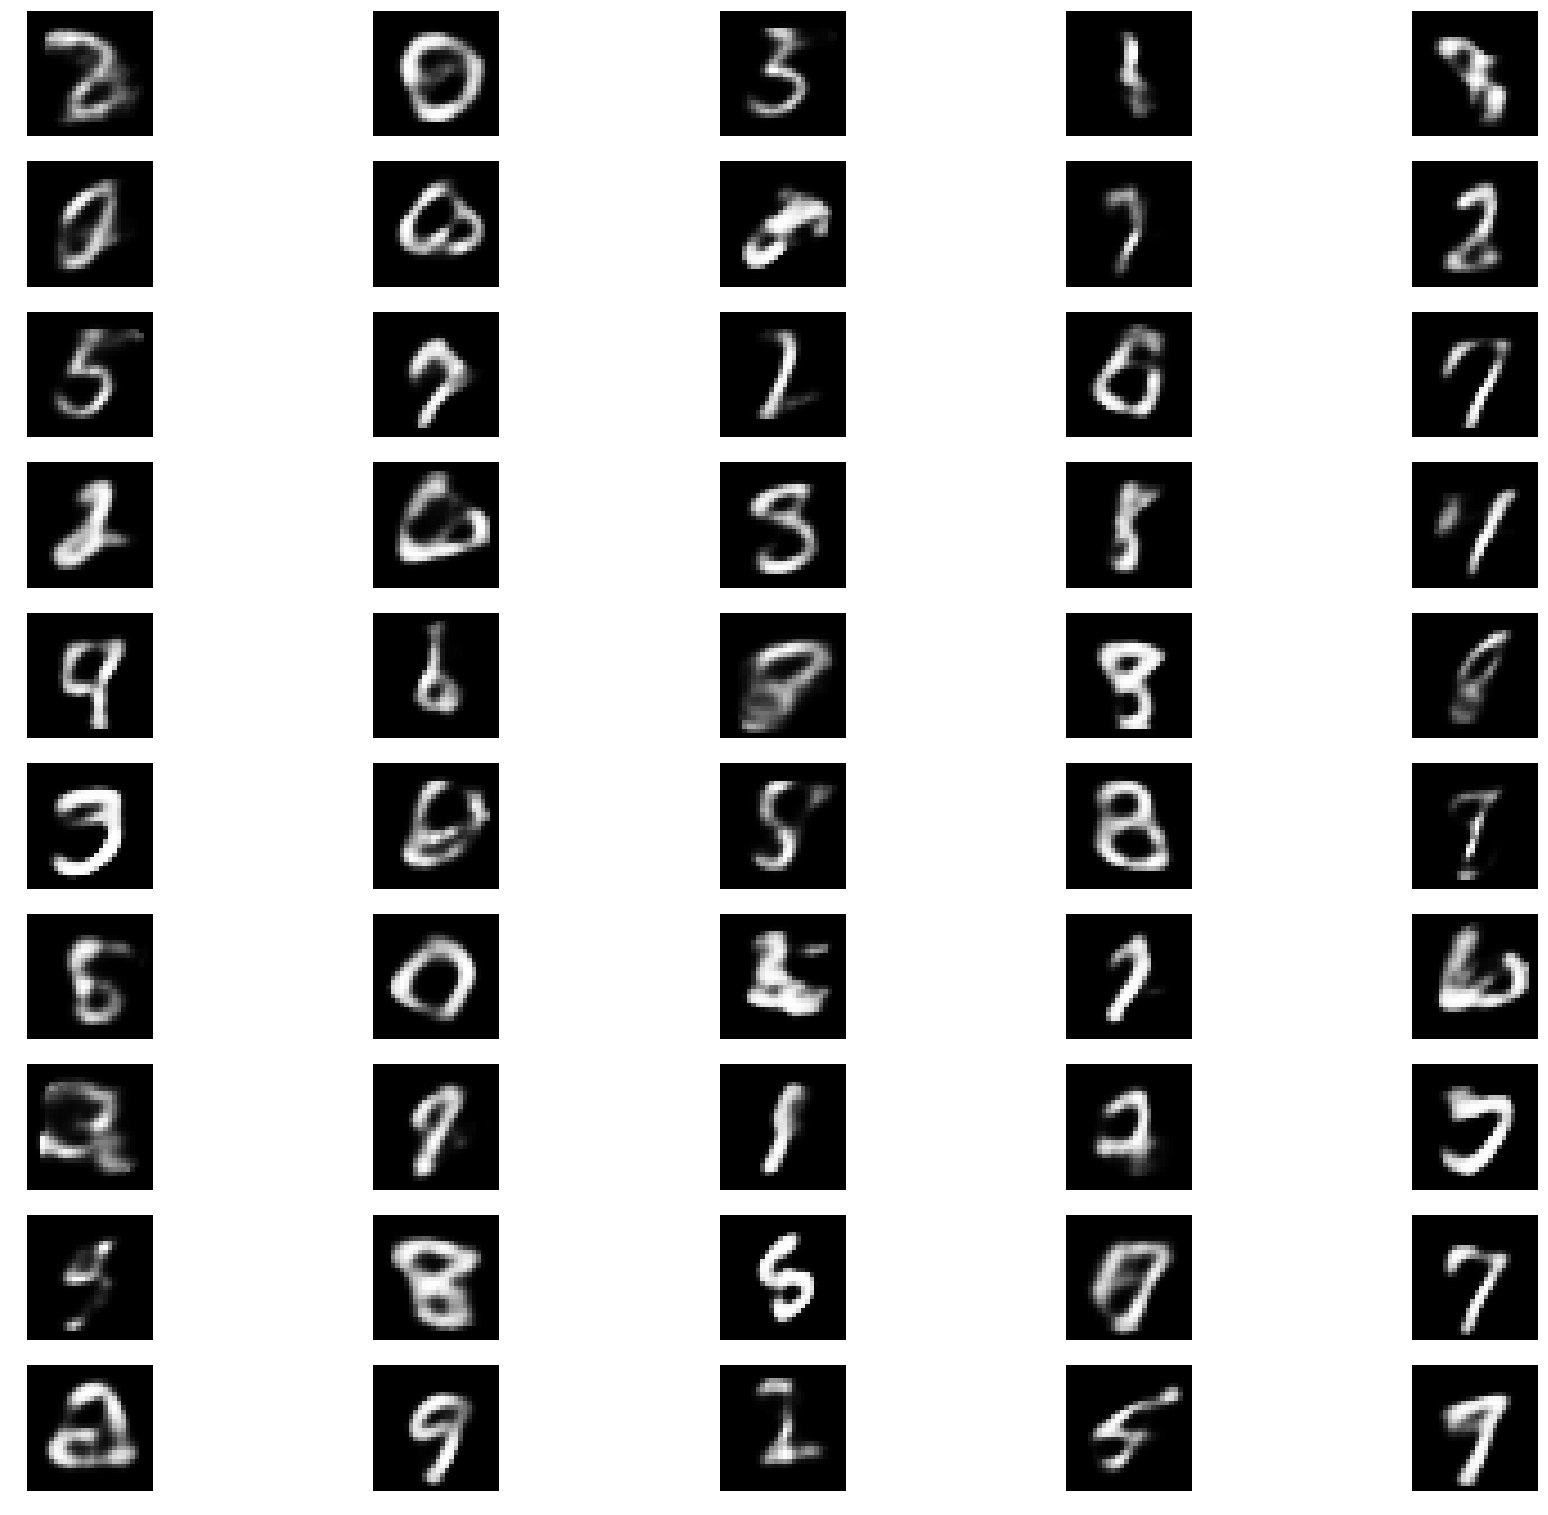

In [11]:
sampled_im_mean_np = sampled_im_mean

plt.figure(figsize = (30,30))
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1, 5, i + 1)
    plt.imshow(sampled_im_mean_np[i, :].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()

## Conditional Variational Autoencoder (CVAE)
[1] Sohn, Kihyuk, Honglak Lee, and Xinchen Yan. “Learning Structured Output Representation using Deep Conditional Generative Models.” Advances in Neural Information Processing Systems. 2015.

In [12]:
# One-hot labels placeholder.
x = Input(batch_shape=(batch_size, original_dim))
label = Input(batch_shape=(batch_size, 10))

encoder = create_encoder(original_dim+10)
get_cond_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_cond_t_log_var = Lambda(lambda h: h[:, latent_dim:])

h = encoder(concatenate([x, label]))
cond_t_mean = get_cond_t_mean(h) # Mean of the latent code (without label) for cvae model.
cond_t_log_var = get_cond_t_log_var(h)# Logarithm of the variance of the latent code (without label) for cvae model.

# YOUR CODE HERE.
t = Lambda(sampling)([cond_t_mean, cond_t_log_var])
decoder = create_decoder(latent_dim+10)
cond_x_decoded_mean = decoder(concatenate([t, label])) # Final output of the cvae model.

In [14]:
conditional_loss = vlb_bernoulli_loss(x, cond_x_decoded_mean, cond_t_mean, cond_t_log_var)
cvae = Model([x, label], cond_x_decoded_mean)
cvae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss=lambda x, y: conditional_loss)

In [15]:
hist = cvae.fit(x=[x_train, y_train],
                y=x_train,
                shuffle=True,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=([x_test, y_test], x_test),
                verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
 - 7s - loss: 142.8147 - val_loss: 121.6013
Epoch 2/15
 - 7s - loss: 118.1446 - val_loss: 113.8006
Epoch 3/15
 - 8s - loss: 113.0440 - val_loss: 110.8482
Epoch 4/15
 - 7s - loss: 110.4608 - val_loss: 108.5393
Epoch 5/15
 - 6s - loss: 108.8315 - val_loss: 106.8903
Epoch 6/15
 - 7s - loss: 107.6676 - val_loss: 106.6306
Epoch 7/15
 - 6s - loss: 106.8041 - val_loss: 106.0948
Epoch 8/15
 - 6s - loss: 106.1191 - val_loss: 105.1536
Epoch 9/15
 - 8s - loss: 105.5845 - val_loss: 104.7802
Epoch 10/15
 - 6s - loss: 105.1424 - val_loss: 104.0917
Epoch 11/15
 - 6s - loss: 104.7305 - val_loss: 104.0899
Epoch 12/15
 - 6s - loss: 104.4208 - val_loss: 103.3671
Epoch 13/15
 - 6s - loss: 104.1097 - val_loss: 103.2331
Epoch 14/15
 - 6s - loss: 103.8457 - val_loss: 103.4432
Epoch 15/15
 - 6s - loss: 103.5881 - val_loss: 102.9727


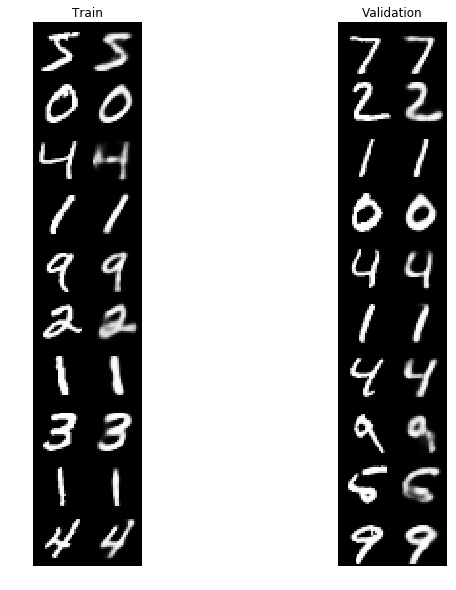

In [16]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (x_data, y_data, title) in enumerate(
            zip([x_train, x_test], [y_train, y_test], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(cond_x_decoded_mean,
                       feed_dict={x: x_data[:batch_size, :],
                                  label: y_data[:batch_size, :]})
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = x_data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

In [17]:
# Prepare one hot labels of form
#   0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 ...
# to sample five zeros, five ones, etc
curr_labels = np.eye(10)
curr_labels = np.repeat(curr_labels, 5, axis=0)  # Its shape is 50 x 10.

sample_t = np.random.normal(loc = 0, scale = 1,size = (n_samples, latent_dim))
# YOUR CODE HERE.
# ...
# cond_sampled_im_mean is a tf.Tensor of size 50 x 784 with 5 random zeros,
# then 5 random ones, etc sampled from the cvae model.
sample_t = np.random.normal(loc = 0, scale = 1,size = (n_samples, latent_dim))
cond_sampled_im_mean = sess.run(cond_x_decoded_mean, feed_dict={t: sample_t, label:curr_labels})

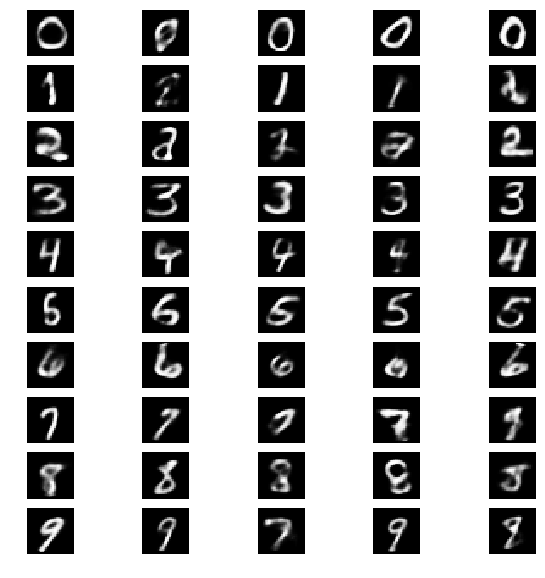

In [18]:
cond_sampled_im_mean_np = cond_sampled_im_mean
# Show the sampled images.
plt.figure(figsize=(10, 10))
global_idx = 0
for digit in range(10):
    for _ in range(5):
        ax = plt.subplot(10, 5, global_idx + 1)
        plt.imshow(cond_sampled_im_mean_np[global_idx, :].reshape(28, 28), cmap='gray')
        ax.axis('off')
        global_idx += 1
plt.show()